In [11]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ['GROQ_API_KEY'] = os.getenv("GROQ_API_KEY")
os.environ['OPENAI_API_KEY'] = os.getenv("OPENAI_API_KEY")
os.environ['TAVILY_API_KEY'] = os.getenv("TAVAILY_API_KEY")


In [5]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings

embd = OpenAIEmbeddings()

urls = [
    "https://platform.openai.com/docs/guides/agents",
    "https://platform.openai.com/docs/guides/supervised-fine-tuning",
    "https://platform.openai.com/docs/guides/vision-fine-tuning",
    "https://platform.openai.com/docs/guides/reinforcement-fine-tuning"
]

docs = [WebBaseLoader(url).load() for url in urls]

doc_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size = 500,
    chunk_overlap = 0
)

doc_splits = text_splitter.split_documents(doc_list)

## add the document to vectorstore

vectorstores = FAISS.from_documents(
    documents=doc_splits,
    embedding=OpenAIEmbeddings()
)

retreiver = vectorstores.as_retriever()

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [6]:
## lets implement the grader
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field


## Datamodel or Grade model
class GradeDoc(BaseModel):
    ## need to retrun binary score as relavance score
    binary_score: str = Field(
        description="document is relevent to the question 'yes' or 'no'"
    )

## llm with function call
llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeDoc)

## Prompt
system = """ You are a grader assessing relevance of a retrieved document to a user question. \n
If the document contains keywords or semnatic meaning related to the question, grade it as relevant.\n
Give a binary score 'yes' or 'no' score to indicate whaether the document is relevent to the question."""

grade_prompt = ChatPromptTemplate.from_messages(
   [
       ('system', system),
       ('human', 'Retrieved document : \n \n {document} \n \n User question: {question}')
   ] 
)

retrieval_grader= grade_prompt | structured_llm_grader
question = 'agent memory'
docs = retreiver.invoke(question)
doc_text = docs[1].page_content
print(retrieval_grader.invoke({'question':question, 'document': doc_text}))


/Users/balmukundmishra/Desktop/Learn-Fine-tune-deploy-LLM-Langchain/venv/lib/python3.10/site-packages/langchain_openai/chat_models/base.py:1669: UserWarning: Cannot use method='json_schema' with model gpt-3.5-turbo-0125 since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


binary_score='no'


In [7]:
## Generate

from langchain import hub
from langchain_core.output_parsers import StrOutputParser

## Prompt

prompt = hub.pull("rlm/rag-prompt")

## llm
llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)

## Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

## Chain
rag_chain = prompt | llm | StrOutputParser()

## Run
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

I don't know.


In [8]:
## Question rewriter

llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)

## Prompt
system = """ You a question re-writer that converts an input question into a better version that is optimized. \n
for websearch, look at the input, and try to reason about the underlying semantic intent / meaning."""

rewrite_prompt = ChatPromptTemplate.from_messages(
    [
        ('system', system),
        ('human',
         'here is the initial question \n\n {question} \n formulate an improved question.'),
    ]
)

question_rewriter = rewrite_prompt | llm | StrOutputParser()

question_rewriter.invoke({'question': question})

'What is the role of memory in artificial intelligence agents?'

In [12]:
## Implementing websearch with Tavily

from langchain_community.tools.tavily_search import TavilySearchResults
web_search_tool = TavilySearchResults(k=3)

In [13]:
from typing import List
from typing_extensions import TypedDict

class GraphState(TypedDict):
    question:str
    generator:str
    web_search:str
    documents : List[str]

In [14]:
from langchain.schema import Document

def retrieve(state):

    print("---RETRIEVE---")

    question = state['question']

    documents = retreiver.invoke(question)
    return {'documents': documents, 'question': question}

def generate(state):

    print("---GENERATE---")
    question = state['question']
    documents = state['documents']
    generation=rag_chain.invoke({"context":documents,"question":question})
    return {"documents":documents, "question":question, "generation":generation}


def grade_documents(state):
    """ Determines wheather the retrieved document is relevent or not.
    Input : Current graph state.
    Output: Updates document key with only filtered relevent documents.
    """

    print("---CHECK DOCUMENT RELEVANCE TO THE QUESTION----")
    question = state['question']
    documents = state['documents']

    ## Score each document.
    filtered_docs = []
    web_search = "No"
    for d in documents:
        score = retrieval_grader.invoke(
            {'question': question, 'document': d.page_content}
        )
        grade = score.binary_score

        if grade=="yes":
            print("--Grade : Document relevent--")
            filtered_docs.append(d)
        else:
            print("--Grade: Document Not Relevent")
            web_search = "yes"
            continue
    return {"documents": filtered_docs, "question": question, "web_search": web_search}


def transform_query(state):
    """ Transform the query to preoduce the better question
    Input : Args: Current Graph State
    Output: Return : update the question key with re-phrased question
    """
    print("--Tranform Query--")
    question = state['question']
    documents = state['documents']

    ## Re-write question

    better_question = question_rewriter.invoke({'question':question})

    return {"documents": documents, "question": better_question}

def web_search(state):
    """ Websearch based on re-phrased question
    Input Args: Current Graph state
    Output Returns: Updates document with appended web search result"""

    print("---web search---")
    question = state['question']
    documents = state['documents']

    ## web-search

    doc = web_search_tool.invoke({'query': question})
    web_result = "\n".join([d['content'] for d in doc])
    web_result = Document(page_content=web_result)
    documents.append(web_result)

    return {"documents": documents, 'question': question}



## Lets define the edges.

def decide_to_generate(state):
    """ Determines wheather to generate an answer, or regenrate the question
    Input Args : Current State Graph
     Output Retunrn : Binary Decision for the next node to call. """
    
    print("--Access Graded Document--")
    question = state['question']
    print(question)
    web_search = state['web_search']
    documents = state['documents']
    print(documents)

    if web_search == "yes":
        print("--Decision: All documents are filtered and nt relevent to the query \n Transform the query")
        return "transform_query"
    else:
        print("--Decision : We have relevent document, so generate the answer--")
        return "generate"




In [16]:
from langgraph.graph import START, END, StateGraph

workflow = StateGraph(GraphState)

workflow.add_node("retrieve", retrieve)
workflow.add_node("grade_document", grade_documents)
workflow.add_node("generate", generate)
workflow.add_node("transform_query", transform_query)
workflow.add_node("web_search_node", web_search)

## Build Graph

workflow.add_edge(START, 'retrieve')
workflow.add_edge('retrieve', 'grade_document')
workflow.add_conditional_edges(
    "grade_document",
    decide_to_generate,
    {
        'transform_query':'transform_query',
        'generate':'generate'
    },
)
workflow.add_edge('transform_query', 'web_search_node')
workflow.add_edge('web_search_node', 'generate')
workflow.add_edge('generate', END)

app = workflow.compile()


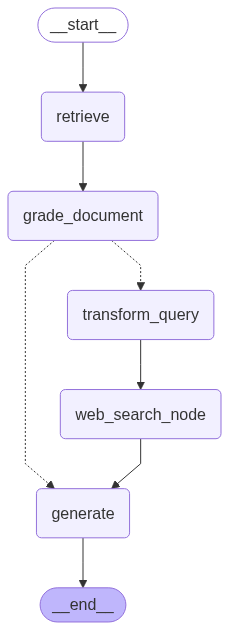

In [17]:
from IPython.display import Image, display
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [18]:
app.invoke({'question': 'what are the type of chunking strategy'})

---RETRIEVE---
---CHECK DOCUMENT RELEVANCE TO THE QUESTION----
--Grade: Document Not Relevent
--Grade: Document Not Relevent
--Grade: Document Not Relevent
--Grade: Document Not Relevent
--Access Graded Document--
what are the type of chunking strategy
[]
--Decision: All documents are filtered and nt relevent to the query 
 Transform the query
--Tranform Query--
---web search---
---GENERATE---


{'question': 'What types of chunking strategies exist?',
 'web_search': 'yes',
 'documents': [Document(metadata={}, page_content="Approach chunking with curiosity and a playful spirit. Experiment with different strategies:\n- **Character Chunking**: Divide the text based on a fixed number of characters.\n- **Recursive Character Chunkiang**: Take it a step further by dividing until a certain condition is met.\n- **Document Specific Chunking**: Respect the document's structure for a coherent breakdown.\n- **Semantic Chunking**: Group chunks based on semantic relationships for meaningful insights. [...] with curiosity and a playful spirit. Experiment with different strategies:  - **Character Chunking**: Divide the text based on a fixed number of characters. - **Recursive Character Chunkiang**: Take it a step further by dividing until a certain condition is met. - **Document Specific Chunking**: Respect the document's structure for a coherent breakdown. - **Semantic Chunking**: Group chunk

In [19]:
app.invoke({'question': 'what are the type of agent memory'})

---RETRIEVE---
---CHECK DOCUMENT RELEVANCE TO THE QUESTION----
--Grade: Document Not Relevent
--Grade: Document Not Relevent
--Grade: Document Not Relevent
--Grade: Document Not Relevent
--Access Graded Document--
what are the type of agent memory
[]
--Decision: All documents are filtered and nt relevent to the query 
 Transform the query
--Tranform Query--
---web search---
---GENERATE---


{'question': 'What are the different types of memory in an agent?',
 'web_search': 'yes',
 'documents': [Document(metadata={}, page_content="Like any computer system, **autonomous AI agents** store and retrieve information. They rely on various types of memory to perform objectives defined by user instructions. By learning the strengths and limitations of each memory type, you will be able to unlock your agents’ full potential.\n\nIn this article, we explore three key types of memory — **long-term memory**, s**hort-term memory**, and **dynamic memory** — in AI agents and how each fits into the larger picture of agent knowledge. [...] Even a well-trained long-term memory can become outdated or miss newly emerging information. The good news is, the last type of agent memory combines the best of both worlds — the benefits of long-term and short-term memory — to pull in additional context on the fly when needed.\n\n**Dynamic memory** allows AI agents to access live, real-time data from you

In [20]:
app.invoke({'question': 'what are AI agents'})

---RETRIEVE---
---CHECK DOCUMENT RELEVANCE TO THE QUESTION----
--Grade: Document Not Relevent
--Grade: Document Not Relevent
--Grade: Document Not Relevent
--Grade: Document Not Relevent
--Access Graded Document--
what are AI agents
[]
--Decision: All documents are filtered and nt relevent to the query 
 Transform the query
--Tranform Query--
---web search---
---GENERATE---


{'question': 'What is the role of AI agents in technology and how do they function?',
 'web_search': 'yes',
 'documents': [Document(metadata={}, page_content="## How do AI Agents Work?\n\nAI agents operate in a continuous cycle: they gather information, analyze it, make decisions, and take action.\n\nThese systems range from simple task-specific bots to advanced, adaptive agents that can reason, plan, and refine their responses based on experience.\n\nLet’s look at the three tasks they run through:\n\n### 1. Perception: Gathering Input [...] AI agents help organizations identify patterns, predict needs, and optimize strategies.\n\nFor example, an AI agent monitoring customer support tickets might detect a recurring product defect, prompting proactive improvements. In finance, AI-powered advisors can analyze market trends and provide real-time investment recommendations. In HR, AI agents can assess employee sentiment through workplace chat analysis, helping companies address concerns be